# Multi-Layer Perceptron for binary-classification / in pytorch

## Objective:

The objective of this lab is to develop a two hidden layers MLP to perform **binary classification**.

We will use a MLP with 2 hidden layer with $n_{h1}=20$ and $n_{h2}=10$ hidden units and ```relu``` activation functions.
You will perform 10.000 iterations (epochs) of SGD to find the parameters.

### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write NN model in pytorch.

We will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,W2,b2,W3,b3), writing the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad.
- **Model B**: using the Sequential class of pytorch
- **Model C**: using a custom torch.nn.Module class

### Loss

Since we are dealing with a binary classification problem, we will use a Binary Cross Entropy loss

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm with a learning rate of 0.1.

Reminder : The optimizer is applied to a set of parameters.

Once the gradients have been computed (after the backpropagation has been performed), we perform one step of optimization (either by hand or with optimizer.step()).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package.  
First, reset the gradients of all parameters then perform the backpropagation

### Documentations:

- Introduction to pytorch

    - https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4
    - https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/#1

- Specific pytorch packages

    - NN: https://pytorch.org/docs/stable/nn.html
    - Autograd: https://pytorch.org/docs/stable/autograd.html
    - Optim: https://pytorch.org/docs/stable/optim.html


## Load the python packages

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'torch'

## Dataset

We take the usual circle dataset from sklearn.

In [ ]:
from sklearn import datasets
X_np, y_np = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

We convert the ```numpy tensors``` to ```torch tensors```.
The difference being that the latters allows to do automatic gradient differentiation (back-propagation).

In [ ]:
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
y = y.view(len(y), 1)

In [ ]:
print(X.size())
print(y.size())
print(X.mean(dim=0))
print(X.std(dim=0))

torch.Size([1000, 2])
torch.Size([1000, 1])
tensor([-0.0133, -0.0021])
tensor([0.6044, 0.5994])


## Normalization

In [ ]:
X -= X.mean(dim=0)
X /= X.std(dim=0)
print(X.mean(dim=0))
print(X.std(dim=0))

tensor([-1.3351e-08,  1.5497e-08])
tensor([1., 1.])


## Definition of the hyper-parameters

In [ ]:
n_in = X.shape[1]
n_h1 = 20 #first layer is 20 units
n_h2 = 10 #second layer is 10 units
n_out = 1 #binary classifation

nb_epoch = 10000
alpha = 0.1

NameError: name 'X' is not defined

## Model 1 (writing the network equations)




### Parameter initialization

**Using torch.Tensors**.
we define the variables and write the equations of the network ourself.
However we will use ```torch.Tensors``` instead of ```numpy.Array```.

***Why ?*** because torch tensors allow us to **automatically** get the gradient.  
Simply using ```loss.backward()``` to launch the backpropagation from ```loss```.  
Then, for all tensors we've created and for which we declared ```requires_grad=True```, we will get the gradient of ```loss```with respect to this variable in the field ```.grad```.

Example: ```W1 = torch.Tensor(..., requires_grad=True)``` ... ```loss.backward``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

**Random initialization**. The weight $W_1, W_2, \cdots$ matrices **should be initialized randomly with small values**; while the bias vectors $b_1, b_2, \cdots$can be initialized to zero.

In [ ]:
# --- We first initialize the variables of the network (W1, b1, ...)

W1 = torch.rand(n_in, n_h1)/100
W1.requires_grad = True
b1 = torch.zeros(n_h1).T
b1.requires_grad = True

W2 = torch.rand(n_h1, n_h2)/100
W2.requires_grad = True
b2 = torch.zeros(n_h2).T
b2.requires_grad = True

W3 = torch.rand(n_h2, n_out)/100
W3.requires_grad = True
b3 = torch.zeros(n_out).T
b3.requires_grad = True


### Define the model

We write a function to perform the forward pass (using pytorch operators, not numpy operators) taking X as input and returing hat_y as output.

In [ ]:
def model(X):
    A0 = X
    Z1 = A0 @ W1 + b1
    A1 = torch.relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = torch.relu(Z2)
    Z3 = A2 @ W3 + b3
    A3 = torch.sigmoid(Z3)
    hat_y = A3
    
    return hat_y

### Main training loop

We iterate over epochs (we do not perform split into mini-batch here).
For each iteration, we
- a) perform the forward pass,
- b) compute the loss/cost,
- c) compute the backward pass to get the gradients of the cost w.r.t. the parameters W1, b1, ...
- d) perform the update of the parameters W1, b1, ...

***Important: pytorch restriction***  
When we update the parameters (W1, b1, ...), we muist do that ``inplace`` (W1 -= ??? and not W1 = W1 - ???).  
**Why?** Because otherwise pytorch will overide W1 by its value, and hence **it will eras its .grad file** used to backpropagate.


In [ ]:
for num_epoch in range(0, nb_epoch):

    # --- a) Forward pass: X (n_in, m), hat_y (n_out, m)
    hat_y = model(X)

    # -- We clip hat_y in order to avoid log(0) in the loss
    eps = 1e-10
    hat_y = torch.clamp(hat_y, eps, 1-eps)

    # --- b) Computing the loss/cost
    loss = - ( y*torch.log(hat_y) + (1-y)*torch.log(1-hat_y)) ##binary cross entropy
    cost = torch.sum(loss)/X.size()[0]


    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, cost))

    # --- c) Backward pass
    cost.backward()

    # --- "with torch.no_grad()" temporarily set all the requires_grad flag to false
    with torch.no_grad():
        # --- d) perform the update of the parameters W1, b1, ...
        # --- the gradients dLoss/dW1 is stored in W1.grad, dLoss/db1 is stored in b1.grad, ...
        W1 -= W1.grad * alpha
        b1 -= b1.grad * alpha
        W2 -= W2.grad * alpha
        b2 -= b2.grad * alpha
        W3 -= W3.grad * alpha
        b3 -= b3.grad * alpha


    # --- We need to set to zero all gradients (otherwise they are cumulated)
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    W3.grad.zero_()
    b3.grad.zero_()

NameError: name 'nb_epoch' is not defined

## Model 2 (using nn.sequential)

Here, we use the package ```torch.nn``` which comes with a predefined set of layers. The syntax is close to the one of ```keras```(```Sequential```), but differs in the fact that layers are splitted into the matrix multiplication followed by a non-linear activations (```keras```merge both using the ```Dense```layers).

The model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. It is therefore a convenient way to write simple sequential networks.

In [ ]:
my_model =  torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.ReLU(),
    torch.nn.Linear(n_h1,n_h2),
    torch.nn.ReLU(),
    torch.nn.Linear(n_h2, n_out),
    torch.nn.Sigmoid(),
    )

NameError: name 'torch' is not defined

### Criterion and Optimization

The code of Model 1 is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model 2) or a class definition of the network (model 3), we still need to define
- what we will minimize (the loss to be minimized, i.e. Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update algorithms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(my_model.parameters(),lr=0.1)

### Main training loop

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [ ]:
loss_l = []
for num_epoch in range(nb_epoch):

    hat_y = my_model(X) # Forward pass: Compute predicted y by passing  x to the model
    loss = criterion(hat_y,y) # Compute loss

    # re-init the gradients (otherwise they are cumulated)
    optimizer.zero_grad()

    # perform back-propagation (which will update the gradients)
    loss.backward()

    # update the weights
    optimizer.step()

    loss_l.append(loss.item())

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))

# ----------------
plt.plot(loss_l)

NameError: name 'nb_epoch' is not defined

## Model 3 (using a class definition)

Here, you will write the network using the recommended pytroch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```.

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super(Net, self).__init__()

        if student:
            # --- START CODE HERE (06)
            self.fc1 = nn.Linear(n_in, n_h1) # hidden layer 1
            self.fc2 = nn.Linear(n_h1, n_h2) # hidden layer 2
            self.fc3 = nn.Linear(n_h2, n_out)  # output layer
            # --- END CODE HERE

    def forward(self, X):

        if student:
            # --- START CODE HERE (07)
            A0 = X
            A1 = torch.relu(self.fc1(A0))   # activation function for hidden layer 1
            A2 = torch.relu(self.fc2(A1))   # activation function for hidden layer 2
            A3 = torch.sigmoid(self.fc3(A2))   # activation function for output layer
            # --- END CODE HERE

        return A3

# --- START CODE HERE
my_model = Net(n_in, n_h1, n_h2, n_out)
# --- END CODE HERE

### Criterion and Optimization (same as for model 2 -> copy and paste your code)

In [ ]:
if student:
    # --- START CODE HERE (08)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(my_model.parameters(),lr=0.1)
    # --- END CODE HERE


### Main training loop (same as for model 2 -> copy and paste your code)


epoch 0, loss 0.6970490217208862
epoch 500, loss 0.30917608737945557
epoch 1000, loss 0.2692456841468811
epoch 1500, loss 0.26258087158203125
epoch 2000, loss 0.2603543996810913
epoch 2500, loss 0.2594291567802429
epoch 3000, loss 0.25883516669273376
epoch 3500, loss 0.2583462595939636
epoch 4000, loss 0.25795912742614746
epoch 4500, loss 0.25772109627723694
epoch 5000, loss 0.25753268599510193
epoch 5500, loss 0.2573728859424591
epoch 6000, loss 0.2572425901889801
epoch 6500, loss 0.25711724162101746
epoch 7000, loss 0.256918340921402
epoch 7500, loss 0.2567879557609558
epoch 8000, loss 0.25659507513046265
epoch 8500, loss 0.2563868463039398
epoch 9000, loss 0.25623080134391785
epoch 9500, loss 0.25608643889427185


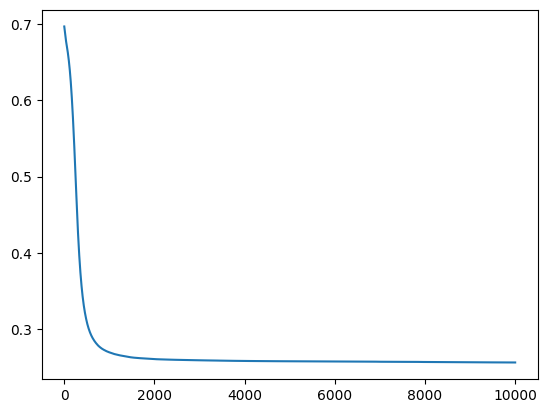

In [ ]:
loss_l = []
for num_epoch in range(nb_epoch):

    if student:
        # --- START CODE HERE (09)
        hat_y = my_model(X) # Forward pass: Compute predicted y by passing  x to the model
        loss = criterion(hat_y,y) # Compute loss

        # Zero gradients, perform a backward pass, and update the weights.

        # re-init the gradients (otherwise they are cumulated)
        optimizer.zero_grad()

        # perform back-propagation
        loss.backward()

        # update the weights
        optimizer.step()
        # --- END CODE HERE

    loss_l.append(loss.item())

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))

# ----------------
plt.plot(loss_l);